In [ ]:
import cv2 
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
from os import listdir
import pandas as pd
import glob
import random
from numpy.core.getlimits import inf


In [ ]:
# size of image
x_size = 168
y_size = 224
path1 = "drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing"

numBGs = 15


In [ ]:
bg_List = []

In [ ]:
almond_list = []

In [ ]:
bad_List = []


In [ ]:
df = pd.read_csv('drive/MyDrive/CE_Capstone_QA_2022-2023/Annotations/BaseDataFrame.csv', delimiter = ',')

In [ ]:
df

,img_name,label,width,height,x0,y0,x1,y1,num_of_boxes,img_width,img_height,bb_x0,bb_y0,bb_x1,bb_y1


In [ ]:
%cd "drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing"

/content/drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing


In [ ]:
%cd almonds/


/content/drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing/almonds


In [ ]:
for i in listdir():
  almond_list.append(cv2.imread(i,cv2.IMREAD_UNCHANGED))


In [ ]:
%cd ..
%cd background(168*224)


/content/drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing
/content/drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing/background(168*224)


In [ ]:
for n in listdir():
  i = cv2.imread(n,cv2.IMREAD_UNCHANGED)
  
  if i is not None:
    im = cv2.resize(i,(168,224), interpolation = cv2.INTER_AREA)
    bg_List.append(im)


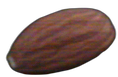

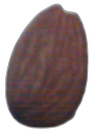

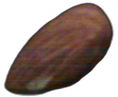

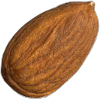

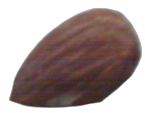

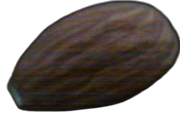

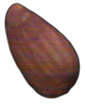

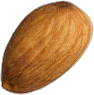

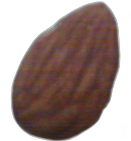

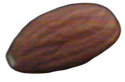

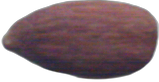

In [ ]:
for i in almond_list:
  cv2_imshow(i)

In [ ]:
def subtract_from_pixels(image,s):
    subtract = s # value to subtract from every pixel
    image = image.astype(np.int16) # convert to int16 to avoid overflow
    subtracted = np.maximum(image - subtract, 0)
    subtracted = np.minimum(subtracted, 255) # avoid overflow
    subtracted = subtracted.astype(np.uint8) # convert back to uint8
    return subtracted


In [ ]:
def multiply_image_by_number(img, number):
    # Multiply the values of each pixel by the given number
    img = np.uint8(np.clip(img * number, 0, 255))
    return img

In [ ]:

def minDistBetween(x,y,pos):
  if len(pos) < 1:
    return inf
  minDist = inf
  for p in pos:
    d = np.sqrt((x - p[0])**2 + (y - p[1])**2)
    minDist = min(d,minDist)
  return minDist
  

In [ ]:
def createSyntheticImage(min_distance = 15, margin = 15):
    b = random.choice(bg_List)
    background = b.copy()
    num_objs = random.randint(1, 1)
    obj_images1 = [random.choice(almond_list) for i in range(num_objs)]
    obj_images = obj_images1.copy()

    positions = []
    # Pick a random location and rotation for the objects
    for obj in obj_images:
        rows, cols, channels = obj.shape
        M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(0, 360), 1)
        obj = cv2.warpAffine(obj, M, (cols,rows))
        newSizeX = int(obj.shape[1] * (random.uniform(1.3,1.8))) 
        obj = cv2.resize(obj,(newSizeX,newSizeX))        
        x_offset = random.randint(0, background.shape[1] - obj.shape[1])
        y_offset = random.randint(0, background.shape[0] - obj.shape[0])
        i = 0
         # Check if any other objects are too close to the current one
  ####
       # while minDistBetween(x_offset,y_offset,positions) < min_distance and i < 50:
           # i += 1
          #  x_offset = random.randint(0, background.shape[1] - obj.shape[1])
         #   y_offset = random.randint(0, background.shape[0] - obj.shape[0])
      #  if(i > 49):
       #   break
        positions.append((x_offset,y_offset))
        gray = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
        gray = multiply_image_by_number(gray,1) 
        gray = np.stack((gray,)*3, axis=-1)     
        gray= cv2.bilateralFilter(gray, 9, 75, 75)
        #obj = multiply_image_by_number(obj,1.3)
        #cv2_imshow(gray)
        gray = cv2.convertScaleAbs(gray, alpha=1.6, beta=0)
        bg = background[y_offset:y_offset+obj.shape[0], x_offset:x_offset+obj.shape[1]]
        
        res = np.where(gray[:,:,3] > 50,obj,bg)
        
        blend = res*(gray/255) * 1.15
       # cv2_imshow(blend)
        graySize = int(gray.shape[0]*1.05)
        gray = cv2.resize(gray,(graySize,graySize))
       # cv2_imshow(gray)
        bg = bg * (1 - gray[:bg.shape[0],:bg.shape[0],:]/255)
       # cv2_imshow(bg)
        result = np.clip(blend+bg,0,255)
        #bg = np.where(gray[:bg.shape[0],:bg.shape[0],:]> 1, bg, (0,0,0))
        #cv2_imshow(bg)
        background[y_offset:y_offset+obj.shape[0], x_offset:x_offset+obj.shape[1]] = result
    return background

In [ ]:
print(bg_List[1].shape)


(224, 168, 3)


In [ ]:
def pasteImg():
  b = random.choice(bg_List)
  background = b.copy()
  num_objs = random.randint(1, 1)
  obj_images1 = [random.choice(almond_list) for i in range(num_objs)]
  obj_images = obj_images1.copy()
  for obj in obj_images:
      rows, cols, channels = obj.shape
      M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(0, 360), 1)
      obj = cv2.warpAffine(obj, M, (cols,rows))
      newSizeX = int(obj.shape[1] * (random.uniform(1.3,1.8))) 
      obj = cv2.resize(obj,(newSizeX,newSizeX))        
      x_offset = random.randint(0, background.shape[1] - obj.shape[1])
      y_offset = random.randint(0, background.shape[0] - obj.shape[0])
      bg = background[y_offset:y_offset+obj.shape[0], x_offset:x_offset+obj.shape[1]]
      


In [ ]:
cv2_imshow(createSyntheticImage(5,5))

IndexError: ignored

In [ ]:
syntheticList = []


In [ ]:
for i in range(1000):
  syntheticList.append(createSyntheticImage(100,35))



In [ ]:
for x in range(50):
  cv2_imshow(syntheticList[x])

In [ ]:
mkdir "shadowed"

In [ ]:
%cd 'shadowed/'



/content/drive/MyDrive/CE_Capstone_QA_2022-2023/synthesizing/SynthesizedImages/shadowed


In [ ]:
for i, img in enumerate(syntheticList):
    cv2.imwrite('image_{}.jpg'.format(i), img)